In [501]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
from datetime import datetime
from urllib.request import urlopen

from bs4 import BeautifulSoup
from requests import get


## one page scrape

In [274]:
#How do we want to count studios? As 1-bedrooms?
studiobedrooms = 1.0
#



In [ ]:
#initialize lists of info:
link=[]
desc=[]
prices=[]

sqfeets=[]
bedrooms = []

hood=[]

In [279]:
#headers = ({'UseIIr-Agent':
#            'Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/41.0.2228.0 Safari/537.36'})

i = 0 #scrape the i^{th} page
    
url = "https://sfbay.craigslist.org/search/apa?availabilityMode=0&s="+str(i)


#response = get(url,headers=headers)
response = get(url)

soup = BeautifulSoup(response.text,'html')

resultrows = soup.find_all(class_="result-row"); #when we do multiple pages, there will be one soup per page.


In [280]:


##
#define lists of info using resultrows
start = time.time()
for row in resultrows:
    
    #hypberlink:
    linki = row.find(class_='result-title hdrlnk')['href']
    link.append(linki)
    
    #description (or title) of listing:
    description = row.find(class_='result-title').text
    desc.append(description)
    
    #price:
    try:
        price=float(  re.compile('[\d]+').search( row.find(class_='result-price').text   ).group()   )
        prices.append(price)
    except:
        prices.append(np.NaN)
    
    #number of bedrooms and square footage:
    try:
        housinginfo = row.find(class_='housing').text
        #bedrooms:
        try:
            br = float(re.compile('\d').search(  re.compile('\dbr').search(housinginfo).group()  ).group()  ) #this mess pulls out number of bedrooms
            #if br is given in housing section
        except AttributeError:
            try: 
                br=re.compile('\d').search(re.compile('(\dbr|\d-br|\d\sbr|\dbdr|\d-bdr|\d\sbedroom|\d-bedroom)').search(description.lower()).group()).group()
                #print('found bedroom in description:'+description)
                #if br is given in description
            except:
                stud=re.compile('studio').search(description.lower())
                if stud is not None:
                    br = studiobedrooms
                else:
                    br=np.NaN
        #square footage:
        try:
            sqfeet = float(re.compile('[\d]+').search( re.compile('[\d]+ft2').search(housinginfo).group() ).group()   )
            sqfeets.append(sqfeet)
        except AttributeError:
            sqfeets.append(np.NaN)
    except AttributeError: #in case 'housing' class doesn't exist for the listing:
        sqfeets.append(np.NaN) #give up on square footage
        #
        try: 
            br=re.compile('\d').search(re.compile('(\dbr|\d-br|\d\sbr|\dbdr|\d-bdr|\d\sbedroom|\d-bedroom)').search(description.lower()).group()).group()
                #print('found bedroom in description:'+description)
                #if br is given in description
        except: #if no appearance of "br" in description, look for "studio":
            stud=re.compile('studio').search(description.lower())
            if stud is not None:
                br = studiobedrooms
            else:
                br=np.NaN
    finally:
        bedrooms.append(br)
        
        
    #neighborhood
    try:
        nh = re.compile('[^)^(]+').search(  row.find(class_='result-hood').text.strip().lower()  ).group()        
        hood.append(nh)
    except:
        hood.append(np.NaN)

end=time.time()

print(f"time to run: {round(end-start,3)}s.")


#    time.sleep(3)

    
#descriptionflat = [x for y in description for x in y] #flatten description list




time to run: 0.043s.


In [281]:
count=0
for i,br in enumerate(bedrooms):
    if str(br) == 'nan':
        count=count+1
print(f"{count} listings still have no bedroom info.")

6 listings still have no bedroom info.


In [278]:
#plenty have no square footage info:
count=0
for i,sq in enumerate(sqfeets):
    if str(sq) == 'nan':
        count=count+1
print(f"{count} listings still have no square footage info.")

26 listings still have no square footage info.


In [ ]:
# #alternately, could search for tags within the whole soup, instead of within each listing.
# #this is slower, and runs the risk of producing lists of mismatched lengths if info is missing for some listings
# #(which it is)

# start=time.time()
# link1 = [a['href'] for a in soup.find_all('a',attrs={'class','result-title hdrlnk'})]

# end = time.time()
# end-start
         

In [198]:
# #to experiment with defining 'hood' differently:
# hoodx=[];
# row = resultrows[0]
# resulthood = row.find(class_="result-hood")
# try:
#     if re.compile('[a-zA-Z/\s]+').search(resulthood.text.strip()) is not None:
#         neighborhood =  re.sub('[\(\)]','', resulthood.text.strip().lower() )  
#         hoodx.append(neighborhood)
#     else:
#         hoodx.append(np.NaN)
# except:
#     hoodx.append(np.NaN)

In [ ]:
##clean up nh data


In [ ]:
cdata = {'description':description,
         'link':link,
         'bedrooms':br,
         'sq. feet':sqfeet,'price':prices}
df = pd.DataFrame(cdata)

## scrape all pages

In [502]:
url = "https://sfbay.craigslist.org/search/apa?availabilityMode=0"

from urllib.request import urlopen
html = urlopen(url)
soup = BeautifulSoup(html,'html')

In [503]:
rangefrom=int(soup.find(class_="rangeFrom").text)
rangeto=int(soup.find(class_="rangeTo").text)
perpage = rangeto-rangefrom+1
print(f"{perpage} listings per page")

totalcount = int(soup.find(class_="totalcount").text)
print(f"There are a total of {totalcount} listings.")

print(f"That makes for {int(totalcount/perpage)} pages.")

120 listings per page
There are a total of 3000 listings.
That makes for 25 pages.


In [611]:
#initialize lists of info:
links=[]
descs=[]
prices=[]

sqfeets=[]
bedrooms = []

hood=[]


#for each page, make a soup, and for each listing in that soup, append to each info list. 
for i in range(0,totalcount,perpage):
    url = "https://sfbay.craigslist.org/search/apa?availabilityMode=0&s="+str(i)
    

    response = get(url)
    soup = BeautifulSoup(response.text,'html')
    resultrows = soup.find_all(class_="result-row");

    ###
    for row in resultrows:
        
        #hyperlink:
        linki = row.find(class_='result-title hdrlnk')['href']
        links.append(linki)

        #description (or title) of listing:
        description = row.find(class_='result-title').text
        descs.append(description)

        #price:
        try:
            price=float(  re.compile('[\d]+').search( row.find(class_='result-price').text   ).group()   )
            prices.append(price)
        except:
            prices.append(np.NaN)

        #number of bedrooms and square footage:
        try:
            housinginfo = row.find(class_='housing').text
            #bedrooms:
            try: #check whether # of bedrooms is given in the "housing" class:
                br = float(re.compile('\d').search(  re.compile('\dbr').search(housinginfo).group()  ).group()  ) #this mess pulls out number of bedrooms
            except AttributeError: #if not, try to find bedroom number in description:
                try: 
                    br=re.compile('\d').search(re.compile('(\dbr|\d-br|\d\sbr|\dbdr|\d-bdr|\d\sbedroom|\d-bedroom)').search(description.lower()).group()).group()

                except: #or maybe the description says it's a studio:
                    stud=re.compile('studio').search(description.lower())
                    if stud is not None:
                        br = studiobedrooms
                    else:
                        br=np.NaN
            #square footage:
            try: #check whether square footage is given in "housing" class:
                sqfeet = float(re.compile('[\d]+').search( re.compile('[\d]+ft2').search(housinginfo).group() ).group()   )
                sqfeets.append(sqfeet)
            except AttributeError: #if not, mark "nan" and move on.
                sqfeets.append(np.NaN)
        except AttributeError: #in case 'housing' class doesn't exist for the listing:
            sqfeets.append(np.NaN) #give up on square footage
            #
            try: #try to find number of bedrooms in description:
                br=re.compile('\d').search(re.compile('(\dbr|\d-br|\d\sbr|\dbdr|\d-bdr|\d\sbedroom|\d-bedroom)').search(description.lower()).group()).group()
            except: #if no appearance of "br" in description, look for "studio":
                stud=re.compile('studio').search(description.lower())
                if stud is not None:
                    br = studiobedrooms
                else:
                    br=np.NaN
        finally: #br has now been defined, even if as "nan"
            bedrooms.append(float(br))


        #neighborhood
        try:
            nh = re.compile('[^)^(]+').search(  row.find(class_='result-hood').text.strip().lower()  ).group()        
            hood.append(nh)
        except:
            hood.append(np.NaN)

        
    
    time.sleep(3) #take a break before scraping the next page

In [612]:
hoods = list(set(hood)); #create a list with each neighborhood found appearing once
hoods = [nh for nh in hoods if str(nh)!='nan']; #exclude "nan" from the list of neighborhoods
         #list(set(hood))[1:] #(get rid of nan)

Many of the neighborhoods are multiple neighborhoods separated by slashes, e.g. "Pleasanton/Livermore".
In the "hoods" list, I want these to be separated.

Also, some "neighborhoods" are just addresses. I want to reduce these to just neighborhood, if given, and get rid of these if not.

In [613]:
hoodssep = hoods[:]

for i,nh in enumerate(hoods):
    if str(nh)!='nan':
        
        #to separate slashed combo neighbrohoods:
        combohood = re.compile('/').search(nh)
        if combohood is not None: #i.e. if a slash appears in the neighborhood
            pieces= (re.compile("[^/]+").findall(nh)) #separate into constituent neighborhoods
            pieces = [p.strip() for p in pieces]
            hoodssep = hoodssep + pieces #append separate neighborhoods to the list
            hoodssep.remove(nh) #remove the slashed combination from the list
            
#remove from hoodssep neighborhoods that have digits (probably addresses:)
hoodssep = [nh for nh in hoodssep if re.compile('[\d]+').search(nh)==None ]

hoodssep = list(set(hoodssep)) #unique neighborhoods

#remove "downtown" (not a useful neighborhood descriptor on its own)

if 'downtown' in hoodssep:
    hoodssep.remove('downtown')


Many listings still have missing neighborhood info. Next try to find neighborhoods in descriptions.

In [614]:
#put the neighborhoods into an "or" set to compile and search for in descriptions:
orhoods=r'(\b'+str(hoodssep[0]);
for nh in hoodssep[1:]:
    orhoods = orhoods + r'\b|\b' + str(nh)
orhoods = orhoods + r'\b)'

printi=0
imax=20

hood2=hood[:]
for i,h in enumerate(hood):
    #if neighborhood is marked nan, check the description:
    if str(h) == 'nan':
        description = descs[i].lower()
        deschood=re.compile(orhoods).search(description)
        if deschood is not None:
            hood2[i] = deschood.group()
            if printi<imax:
                print(f"A: Fixed listing {i}: hood was {h} and is now {hood2[i]}.")
                printi=printi+1
       
    else:      
        #deal with addresses (and zip codes):
        numaddress = re.compile('[\d]+').search(h) #digits in "neighborhood" usually indicate it's an exact address
        #check whether any of the neighborhoods listed in "hoodssep" appear in the address itself:
        if numaddress is not None:
            nhinaddress=re.compile(orhoods).search(h)
            if nhinaddress is not None:
                hood2[i] = nhinaddress.group()
                if printi<imax:
                    print(f"B: Fixed listing {i}: hood was {h} and is now {hood2[i]}.")
                    printi=printi+1
            elif deschood is not None:
                hood2[i] = deschood.group()
                if printi<imax:
                    print(f"C: Fixed listing {i}: hood was {h} and is now {hood2[i]}.")
                    printi=printi+1
            else:
                hood2[i] = np.nan
                if printi<imax:
                    print(f"D: Fixed listing {i}: hood was {h} and is now {hood2[i]}.")
                    printi=printi+1

B: Fixed listing 131: hood was 2301 84th ave. oakland, ca 94605 and is now oakland.
A: Fixed listing 292: hood was nan and is now los gatos.
B: Fixed listing 355: hood was potrero 1010 and is now potrero.
A: Fixed listing 408: hood was nan and is now petaluma.
B: Fixed listing 409: hood was 146 ardith dr, orinda, ca 94563 and is now orinda.
B: Fixed listing 413: hood was 146 ardith dr, orinda, ca 94563 and is now orinda.
B: Fixed listing 415: hood was 146 ardith dr, orinda, ca 94563 and is now orinda.
B: Fixed listing 419: hood was 146 ardith dr, orinda, ca 94563 and is now orinda.
A: Fixed listing 475: hood was nan and is now petaluma.
A: Fixed listing 481: hood was nan and is now petaluma.
A: Fixed listing 483: hood was nan and is now petaluma.
B: Fixed listing 604: hood was 2900 saint paul drive santa rosa, ca and is now santa rosa.
B: Fixed listing 682: hood was 35 harkins slough rd watsonville ca and is now watsonville.
B: Fixed listing 731: hood was 220 diablo ave, mountain view 

In [615]:
#because hoodssep was used to construct hood2,
#new neighborhoods may have been introduced,
#that did not stand alone (only slashed with others) in "hoods":
list(set(hood)) == list(set(hood2))

False

In [616]:
#redefine hoods and hoodssep
hoods = list(set(hood)); #create a list with each neighborhood found appearing once
hoods = [nh for nh in hoods if str(nh)!='nan']; #exclude "nan" from the list of neighborhoods
         #list(set(hood))[1:] #(get rid of nan)
    
hoodssep = hoods[:]

for i,nh in enumerate(hoods):
    if str(nh)!='nan':
        
        #to separate slashed combo neighbrohoods:
        combohood = re.compile('/').search(nh)
        if combohood is not None: #i.e. if a slash appears in the neighborhood
            pieces= (re.compile("[^/]+").findall(nh)) #separate into constituent neighborhoods
            pieces = [p.strip() for p in pieces]
            hoodssep = hoodssep + pieces #append separate neighborhoods to the list
            hoodssep.remove(nh) #remove the slashed combination from the list
            
#remove from hoodssep neighborhoods that have digits (probably addresses:)
hoodssep = [nh for nh in hoodssep if re.compile('[\d]+').search(nh)==None ]

hoodssep = list(set(hoodssep)) #unique neighborhoods

#remove "downtown" (not a useful neighborhood descriptor on its own)

if 'downtown' in hoodssep:
    hoodssep.remove('downtown')

As pulled from Craigslist, "San Francisco" is broken down into many neighborhoods. I would like to lump these all into "san francisco", so I can have enough samples per neighborhood to do statistics.

I'll try scraping neighborhood names from Wikipedia:

In [617]:
urlsfnh="https://en.wikipedia.org/wiki/List_of_neighborhoods_in_San_Francisco"

htmlsfnh=urlopen(urlsfnh)

soupsfnh = BeautifulSoup(htmlsfnh,'html')

allsections=soupsfnh.select('.toclevel-1')

sfhoods=[];
for sec in allsections:
    sfhoods.append(re.compile("[a-z\s/'-]+").search(sec.text.lower()).group().strip())
    
sfhoods = [nh for nh in sfhoods if nh.lower() not in ['see also','references', 'external links']]

In [618]:
urloak="https://en.wikipedia.org/wiki/List_of_neighborhoods_in_Oakland,_California"

htmloak=urlopen(urloak)

soupoak = BeautifulSoup(htmloak,'html')

allsections=soupoak.select('.toclevel-1')

oakhoods=[];
for sec in allsections:
    oakhoods.append(re.compile("[a-z\s/'-]+").search(sec.text.lower()).group().strip())
    
oakhoods=[nh for nh in oakhoods if nh.lower() not in ['see also','references', 'external links']]

In [619]:


#use scraped info about sf and oakland neighborhoods to lump:
hood3=hood2[:];

imax = 200#len(hood2)#set to limit print-outs
for i,nh in enumerate(hood2):
    if nh in sfhoods:
        hood3[i] = 'san francisco'
        if i<imax:
            print(f"Changed '{nh}' to '{hood3[i]}'.")
            
    elif nh in oakhoods:
        hood3[i] = 'oakland'
        if i<imax:
            print(f"Changed '{nh}' to '{hood3[i]}'.")
    elif str(nh)!='nan':
        if re.compile('san jose').search(nh) is not None:
            hood3[i] = 'san jose'
            if i<imax:
                print(f"Changed '{nh}' to '{hood3[i]}'.")

        
        combo = re.compile('/').search(nh)
        if combo is not None:
            pieces = re.compile('[^/]+').findall(nh)
            pieces = [p.strip() for p in pieces]
            for pc in pieces:
                if pc in sfhoods:
                    hood3[i] = 'san francisco'
                    if i<imax:
                        print(f"Changed '{nh}' to '{hood3[i]}'.")
                if pc in oakhoods:
                    hood3[i] = 'oakland'
                    if i<imax:
                        print(f"Changed '{nh}' to '{hood3[i]}'.")


Changed 'san jose north' to 'san jose'.
Changed 'san jose south' to 'san jose'.
Changed 'soma / south beach' to 'san francisco'.
Changed 'san jose north' to 'san jose'.
Changed 'west san jose / willow glen area' to 'san jose'.
Changed 'san jose north' to 'san jose'.
Changed 'oakland hills / mills' to 'oakland'.
Changed 'san jose downtown' to 'san jose'.
Changed 'san jose north' to 'san jose'.
Changed 'soma / south beach' to 'san francisco'.
Changed 'north beach / telegraph hill' to 'san francisco'.
Changed 'north beach / telegraph hill' to 'san francisco'.
Changed 'san jose south' to 'san jose'.
Changed 'oakland hills / mills' to 'oakland'.
Changed 'san jose west' to 'san jose'.
Changed 'oakland hills / mills' to 'oakland'.
Changed 'oakland hills / mills' to 'oakland'.
Changed 'twin peaks / diamond hts' to 'san francisco'.
Changed 'noe valley' to 'san francisco'.
Changed 'noe valley' to 'san francisco'.
Changed 'soma / south beach' to 'san francisco'.
Changed 'pacific heights' to 'san 

In [620]:
#re-define hoods for hood3 (neighborhoods including those found in descriptions, and after lumping)
hoods = list(set(hood3))
hoods = [nh for nh in hoods if str(nh)!='nan']

In [621]:
## other cleaning? e.g. remove ", ca" from ends of neighborhoods


def rchop(thestring, ending):
    if thestring.endswith(ending):
        return thestring[:-len(ending)]
        print(f"{thestring}-->{thestring[:-len(ending)]}")
    return thestring

#somestring = rchop(somestring, ' rec')

for i,nh in enumerate(hood3):
    if str(nh)!='nan':
        hood4[i] = rchop(nh, ', ca')
        hood4[i] = rchop(nh, ',ca')
            
    ####FIX THIS: needs to only strip ending "ca"

        
#re-define hoods for hood4 (neighborhoods including those found in descriptions, and after lumping, and with ",ca" removed.)
hoods = list(set(hood4))
hoods = [nh for nh in hoods if str(nh)!='nan']

In [622]:
#make a data frame (and save to csv)
cdata = {'description':descs,
         'link':links,
         'bedrooms':bedrooms,
         'sq. feet':sqfeets,
         'neighborhood':hood4, #note: using the (partially) cleaned hood4
         'price':prices}
df = pd.DataFrame(cdata)



df.to_csv('craigslist_bay_area_rentals.csv')
#df = pd.read_csv('craigslist_bay_area_rentals.csv',index_col=0)

In [623]:
#still missing neighborhoods?
print(f"There are {  len(df[df['neighborhood'].isna()])  } listings with missing neighborhood information.")
      
      

There are 0 listings with missing neighborhood information.


Drop duplicate postings, remove rows with missing data (and sometimes rescale so all features have similar range).

In [624]:

df_no_duplicates=df.drop_duplicates(subset=['description','price'])


dfclean=df_no_duplicates.dropna()[:] #remove rows with missing data

#not using area as a feature now
#dfclean['1000sqfeet']=dfclean['sq. feet']/1000  #normalize so all features are order 1 (no area is in 1000s of square feet)
#no need to rescale price when only using one feature per neighborhood
#dfclean['pricek']=dfclean['price']/1000 #normalize so all features are order 1 (price is in thousands of dollars)

#discard listings with truly enormous rent (probably actually for sale)
dfclean=dfclean.loc[dfclean['price']<1e4]


In [625]:
#narrow down neighborhoods considered. there are too many, with not enough samples for most.
byhood=dfclean.groupby(by='neighborhood').count()['description'].sort_values(ascending=False)
maxhoods=list(byhood[byhood>50].index) #pick off only neighborhoods with >50 listings

In [626]:
#not using these now
# #neighborhood dummy variables

# for nh in maxhoods:
#     if type(nh) is not float:
#         dfclean[nh]=np.zeros(len(dfclean))
#         dfclean.loc[dfclean['neighborhood']==nh,nh]=1

In [627]:
maxhoods

['san jose',
 'san francisco',
 'fremont / union city / newark',
 'sunnyvale',
 'santa clara',
 'santa rosa',
 'mountain view',
 'dublin / pleasanton / livermore',
 'danville / san ramon',
 'berkeley',
 'campbell',
 'concord / pleasant hill / martinez']

## build a data frame with only the neighborhoods from maxhoods

In [629]:
#let's just consider neighborhood and price per room as features.

#make a new dataframe with only listings in these neighborhoods
listofframes=[];
for i,nh in enumerate(maxhoods):
    dfnh=dfclean.loc[dfclean['neighborhood']==nh]
    listofframes.append(dfnh)

dflim=pd.concat(listofframes)

#add a feature: rent per room
dflim['rent per room'] = dflim['price']/dflim['bedrooms'];

## visualize

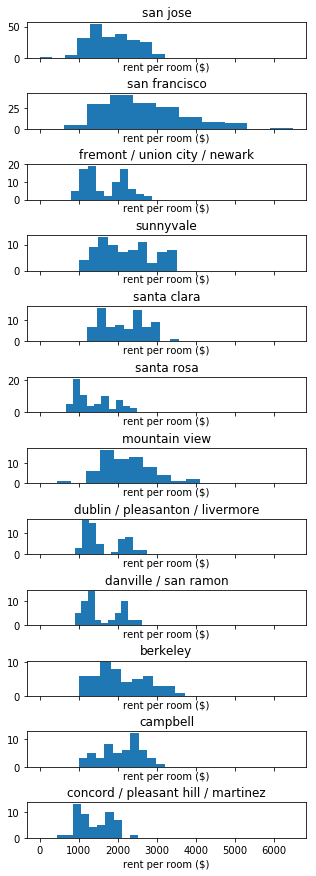

In [630]:
#plot price distributions for each neighborhood
fig,ax = plt.subplots(len(maxhoods),figsize=(5,15),sharex=True)
plt.subplots_adjust(hspace=1)
for i,nh in enumerate(maxhoods):
    ax[i].hist(dflim.loc[dflim['neighborhood']==nh]['rent per room'],bins=10)
    ax[i].set_title(nh)
    ax[i].set_xlabel('rent per room ($)')

In [632]:
# cm = plt.cm.get_cmap('tab10')
# colors = [cm(1.*i/10) for i in range(len(maxhoods))];
# cdict = dict(zip(maxhoods,colors))
# clist = [cdict[nh] for nh in maxhoods]


# fig,ax=plt.subplots(figsize=(12,12))

# nhcount=[]
# legendlist=[];
# for i,nh in enumerate(maxhoods):
#     dfnh=dfclean.loc[dfclean['neighborhood']==nh].sample(frac=1)
#     ax.scatter(dfnh['sq. feet'],dfnh['price'],c=clist[i])
#     legendlist.append(nh)
#     nhcount.append([nh,len(dfnh)])
# ax.legend(legendlist);#,bbox_to_anchor = (1,1));
# ax.set_xlabel('sq. feet');
# ax.set_ylabel('price ($)');

## fit a gaussian to rent per room data, for each neighborhood

In [633]:
#for each neighborhood, just fit price to a (1-dimensional) gaussian.


#dfsimple = dfclean[['rent per room']+maxhoods]
#dfsimple.head()

##split off some test data
#actually, no need, since i have no labels anyway.
dftrain=dflim[:]
#dftrain=dflim.sample(frac=.7)
#dftest = dflim.drop(dftrain.index)



Xnhs=[];
munh=[];
signh=[];
for nh in maxhoods:
    Xnh = dftrain.loc[dftrain['neighborhood']==nh]['rent per room'].values
    Xnhs.append(Xnh)
    munh.append(np.mean(Xnh));
    signh.append(np.std(Xnh));
    


In [634]:
print(f"The mean rent per room in San Francisco is ${np.round(munh[maxhoods.index('san francisco')],2)}.")

The mean rent per room in San Francisco is $2692.0.


But the price distributions tend to have long tails in the higher price ranges, which pulls the mean up. The most common prices are usually a bit below the mean. In a future iteration of this project, I'll try to account for this by using a skewed distribution.

In [635]:
#define gaussian in case i ever need it..
def gauss(x,mu,sig):
    pi=np.pi
    norm = ((2*pi)**.5)*sig
    exponent = (x-mu)**2/(2*sig**2)
    return np.exp(-exponent)/norm

## Flag listings with rent per room sufficiently below the neighborhood mean:

In [636]:
sigmas=1 #number of standard deviations from mean to be called an anomaly
def isitadeal(rent_per_room,nh): 
    mu = munh[ maxhoods.index(nh) ];
    sig = signh[ maxhoods.index(nh) ];
    if rent_per_room < mu - sigmas*sig:
        return(1)
    else:
        return(0)
    
#     if len(rent_per_room) != len(nh):
#         print('Oh no! Input arrays must be the same length.')
#     else:
#         prediction=np.zeros(len(rent_per_room))
#         prediction[rent_per_room < mu - sigmas*sig]  = 1


In [640]:
pp=dflim['rent per room'].values
nh = dflim['neighborhood'].values

predictions=np.zeros(len(dflim))
for i in range(len(pp)):
    predictions[i] = isitadeal(pp[i],nh[i])
    
dflim['deal?'] = predictions

print('Here are the (possible) deals or scams:')
dfdeals=dflim.loc[dflim['deal?']==1][['description','link','bedrooms','neighborhood','price','rent per room']].sort_values(by='rent per room')

dfdeals.head()

Here are the (possible) deals or scams:


,description,link,bedrooms,neighborhood,price,rent per room
122,One month free for two story house,https://sfbay.craigslist.org/sby/apa/d/san-jos...,2.0,san jose,1.0,0.500000
1543,BE CAUTIOUS OF LISTINGS THAT LOOK TOO GOOD TO ...,https://sfbay.craigslist.org/eby/apa/d/oakley-...,3.0,concord / pleasant hill / martinez,1300.0,433.333333
2470,"AC, Wood floors, Sunlight, near Facebook and G...",https://sfbay.craigslist.org/pen/apa/d/mountai...,3.0,mountain view,1350.0,450.000000
2077,Room available in large Marina apartment,https://sfbay.craigslist.org/sfc/apa/d/san-fra...,3.0,san francisco,1900.0,633.333333
1985,178 Hazelnut Lane,https://sfbay.craigslist.org/nby/apa/d/santa-r...,4.0,santa rosa,2650.0,662.500000


sanity check: Indeed, it seems homes with more rooms are cheaper per room.

In [639]:
NH = 'Sunnyvale'
NH = NH.lower().strip()


from IPython.core.display import display, HTML

#links= dfdeals.loc[dfdeals['neighborhood']==NH]['link'].values
#X = np.array(dfdeals.loc[dfdeals['neighborhood']==NH][['rent per room','neighborhood','bedrooms']])
links= dfdeals['link'].values
X = np.array(dfdeals[['rent per room','neighborhood','bedrooms']])


print('with links:')
#count=0
for i,x in enumerate(X):
    rent=x[0];
    nh=x[1];
    bedrooms=x[2];
    if isitadeal(rent,nh)==1:
        #print(f"A {x[1]} sq. foot {x[0]}-bedroom home for ${x[2]} is anomalous:")
        display(HTML("<a href="+links[i]+" target='_blank'> $"+str(np.round(rent))+" per room in a "+str(nh).capitalize()+" "+str(int(bedrooms))+"-bedroom. </a>"))
#        count=count+1

#print(count)


with links:


## TO DO:

Sometimes this misrepresents rent per room, e.g. if someone is renting out just 1 room in a 2-bedroom, and has listed rent for just the 1 room, but has posted the listing as a "2-bedroom". Can I find a way to correct this error by looking for particular words in the description/title?

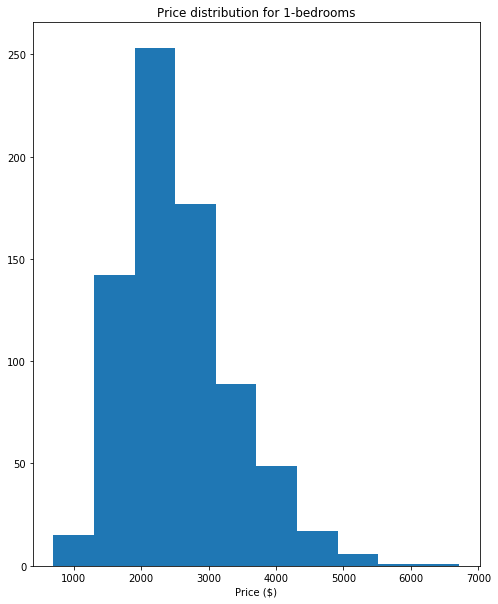

In [35]:
#plot the price distribution of 1-bedrooms from the training and test data

fig,ax =plt.subplots(1,1, figsize=(8,10))
ax.hist(dfclean.loc[dfclean['bedrooms']==1.0]['price']);
ax.set_xlabel('Price ($)');
ax.set_title('Price distribution for 1-bedrooms');



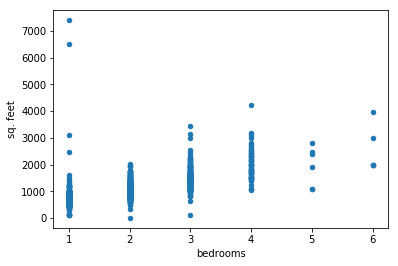

In [37]:
dfclean.plot('bedrooms','sq. feet',kind = 'scatter')

Text(0,0.5,'mean area (ft$^2$)')

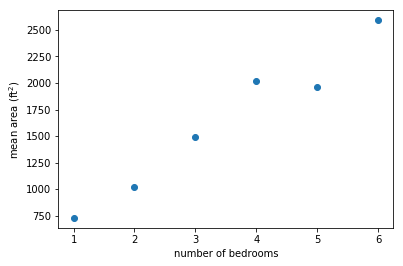

In [38]:
groupedbybedrooms = dfclean.groupby(by='bedrooms').mean();
plt.plot(groupedbybedrooms.index.values,groupedbybedrooms['sq. feet'],'o')
plt.xlabel('number of bedrooms')
plt.ylabel('mean area (ft$^2$)')

In [361]:
#train for anomaly detection and make predictions


# #compute the mean
# mu = train[['bedrooms','1000sqfeet', 'pricek']].mean().values
# #mu = np.array(np.mean(train)[['bedrooms','1000sqfeet','pricek']])
# xminusmu = np.array(train[['bedrooms','1000sqfeet', 'pricek']]-mu)

# #compute covariance matrix
# m=xminusmu.shape[0]
# Sigi=0;
# for i in range(0,m):
#     Sigi=Sigi+np.outer(xminusmu[i], (xminusmu[i]).T)
# Sig=(1/m)*Sigi
# detSig = np.linalg.det(Sig)

# Siginv = np.linalg.inv(Sig)
# n=len(mu)
# def p(x):
#     #p takes x in [bedrooms, square feet, dollars]
#     y=np.array([x[0],x[1]/1000,x[2]/1000]) #convert to 1000s of sq feet, 1000s of dollars
#     exp=np.e**(-.5*np.dot(y-mu,np.dot(Siginv,y-mu)))
#     return(exp/( (2*np.pi)**(n/2)*(detSig**(1/2)) ))


def multigauss(X,mu,Sig):  #input X is m by n (must be in the form of a 2-d array). inputs (X, mu, Sig) should be in 1000sqfeet, 1000$.
        #if mu[1]>X[0,1]*10 or mu[1]<X[0,1]/10:
        #    print('Make sure mu and X are in the same units.')
        n = X.shape[1];
        m = X.shape[0];
        Xminusmu = X-mu
        pi = np.pi
        det = np.linalg.det(Sig)
        inv = np.linalg.inv(Sig)
        exponent=-.5*np.reshape([np.dot( (X[i,:]-mu),  np.dot(inv,(X[i,:]-mu).T)) for i in range(0,m)],(m,1))
        return np.reshape(((2*pi)**(-.5*n))*(det**-.5)*np.exp(exponent),(m,))
    
    
#CHANGE FEATURES HERE 
featureset = ['bedrooms','pricek'];
n = len(featureset)


#fit mu, Sig for each neighborhood separately
nhmu = np.zeros((len(maxhoods),n))
nhSig = np.zeros((len(maxhoods),n,n))
for i,nh in enumerate(maxhoods):
    if type(nh)==str:
        #print(nh)
        dfnh = train.loc[train['neighborhood']==nh]
        if len(dfnh) is not 0:
            Xtrain = np.array(dfnh[featureset])
            m = Xtrain.shape[0]
            mu = np.mean(Xtrain,0)
            Xminusmu=Xtrain-mu
            Sig=(1/m)*np.dot(Xminusmu.T,Xminusmu)
            nhmu[i] = mu
            nhSig[i] = Sig
        else:
            nhmu[i]=np.nan
            nhSig[i]=np.nan
    else:
        nhmu[i]=np.nan
        nhSig[i]=np.nan
    

    
    
    


In [442]:
#e.g. mu and sigma for sunnyvale:
svmu=nhmu[maxhoods.index('sunnyvale')]
svSig=nhSig[maxhoods.index('sunnyvale')]

def svp(X):
    return multigauss(X,svmu,svSig)

svtest = test.loc[test['neighborhood']=='sunnyvale'][:]


svXtest=svtest[featureset].values


svtest['probability'] = svp(svXtest)
svtest[['description']+featureset+['probability']].sort_values(by='probability')


,description,bedrooms,pricek,probability
592,Single home in Homestead High district,4.0,5.000,0.000156
670,Beautiful New Construction - Skip the commute,3.0,4.500,0.015356
474,"Leasing Now, Near Shops and Dining, Business S...",2.0,4.500,0.016573
57,2-bedroom in convenient Sunnyvale location!,2.0,2.300,0.069692
1292,"Apartment Floorplans, EV Chargers, Swegles Par...",2.0,4.175,0.070305
1359,"Subterranean Parking, Comfort and Convenience,...",2.0,4.145,0.078625
2832,2 Bedroom/ 1 Bath Apartment- Nice Small Buildi...,2.0,2.420,0.106776
2021,"Bright and spacious 2-bedroom, 1-bath",2.0,2.500,0.137386
2551,1 Bedroom with gorgeous layout and endless ame...,1.0,3.250,0.177891
467,Come Home to Comfort and Convenience!,1.0,3.023,0.263076


## dont' know why this is not normalized how I expect --- come back to this later

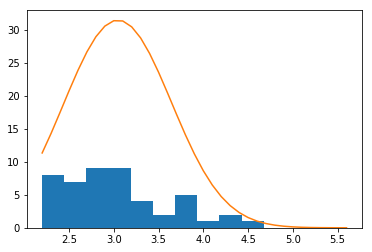

In [439]:
brrange = np.arange(min(dfsv['bedrooms']),max(dfsv['bedrooms']+1))
pprange = np.arange(min(dfsv['pricek']),max(dfsv['pricek']+1),.1)

plt.hist(dfsv['pricek'])
plt.plot(pprange,[len(dfsv['pricek'])*np.sum([multigauss(np.array([[br,pp]]),svmu,svSig) for br in brrange]) for pp in pprange])


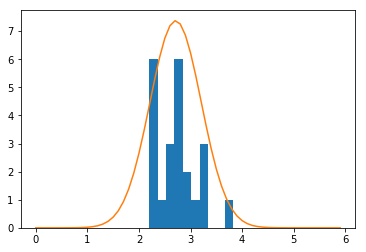

In [433]:
#this seems fine:

plt.hist(dfsv.loc[dfsv['bedrooms']==1]['pricek'])
plt.plot(pprange,[len(dfsv.loc[dfsv['bedrooms']==1])*multigauss(np.array([[1,pp]]),svmu,svSig) for pp in pprange])


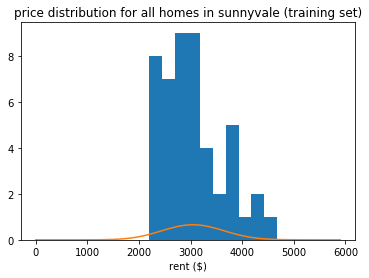

In [329]:
dfsv = train.loc[train['neighborhood']=='sunnyvale']

pprange = np.arange(0,6,.1);
plt.hist(dfsv['price'])
plt.plot(1000*pprange,np.array([np.sum([svp(np.array([[br,pp]])) for br in range(1,4)]) for pp in pprange]))
plt.xlabel('rent ($)')
plt.title('price distribution for all homes in sunnyvale (training set)');




Expected price given bedrooms and square footage: (want to use this to pick only anomalies where price is lower than expected)

In [385]:
XY[:,0]

array([0, 0, 0, 1, 1, 1, 1, 2, 3])

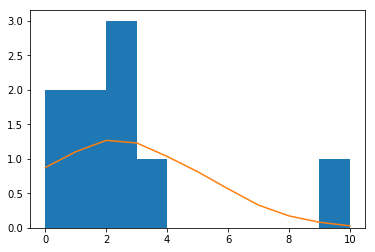

In [423]:
X = [0,0,0,1,1,1,1,2,3];
Y = [0,1,1,0,2,2,2,3,10];

XY = np.array([X,Y]).T



def gauss(x):
    xmu=np.mean(X);
    xsig=np.std(X);
    return((1/(((2*np.pi)**.5)*xsig))*np.exp(-(x-xmu)**2/(2*xsig**2)))

muXY=np.mean(XY,axis=0)



m=len(X);
SigXY=(1/m)*np.dot((XY-muXY).T,XY-muXY)

def multigaussXY(x,y):
    return multigauss(np.array([[x,y]]),muXY,SigXY)

xrange = np.arange(min(X),max(X)+1);
yrange = np.arange(min(Y),max(Y)+1);

plt.hist(Y)
plt.plot(yrange, [len(XY)*np.sum([multigaussXY(x, y) for x in xrange]) for y in yrange] )

In [292]:
brrange=list(set(dfsv['bedrooms']));
print(brrange)
.1*np.sum([np.sum([svp(np.array([[br,pp]])) for br in brrange]) for pp in pprange])

[1.0, 2.0, 3.0]


0.9725048005531944

(or see below for the quick and dirty method of finding expected price)

In [1222]:
bdrs = 1;
ksqfeet = 1;

pricerange = np.arange(0,50,.1);
probprice=[p(np.array([[bdrs, ksqfeet, kdollars]]), mu, Sig) for kdollars in pricerange]
maxid = np.argmax(probprice)


pricerange[maxid]*1000

3300.0000000000005

Now define function using this to say whether a given price is cheap:

In [1223]:
def isitcheap(X,mu,Sig):
    m=X.shape[0]
    n=X.shape[1]
    
    br = X[:,0]
    sqft = X[:,1]
    price = X[:,2]
    
    dz = 1;
    zmax = 100;
    pricerange = np.arange(0,zmax,dz);
    
    norm = np.zeros(m)
    exp_price = np.zeros(m)
    
    for i in range(0,m):
        norm[i] = dz*np.sum([p(np.array([[br[i],sqft[i],z]]),mu,Sig) for z in pricerange]);
        exp_price[i] = dz*np.sum([z*p(np.array([[br[i],sqft[i],z]]),mu,Sig) for z in pricerange])/norm[i];
    
    return price<exp_price
#returns "True" if price is lower than expected given br and sqft

In [1224]:
#define expected price seprately
def exp_price(br,sqft,mu,Sig):
    norm = dz*np.sum([p(np.array([[br,sqft,z]]),mu,Sig) for z in pricerange]);
    exp_price = dz*np.sum([z*p(np.array([[br,sqft,z]]),mu,Sig) for z in pricerange])/norm;
    return exp_price

In [1225]:
exp_price(4,1.15,mu,Sig)*1000

3325.39439869261

### Define probability density for price, given fixed number of bedrooms and square footage.

Text(0.5,1,'(Normalized) distribution for price, for 1-bedroom, 1000 sq-foot homes')

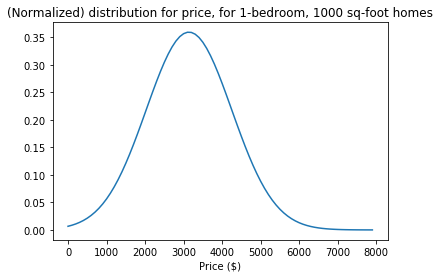

In [1095]:
br = 1;
sqft = 1;

dz=.1;
zmax = 8;
    
def pz(x0,y0,z):

    norm=dz*np.sum([p(np.array([[1,1,z]]),mu,Sig) for z in np.arange(0,zmax,dz)]);
    return p(np.array([[x0,y0,z]]),mu,Sig)/norm

#plt.plot(pricerange,[pz(1,1,z) for z in pricerange])

pricerange=np.arange(0,zmax,dz)
pzrange=np.reshape([pz(1,1,z) for z in pricerange],(len(pricerange),));

plt.plot(pricerange*1000,pzrange)
plt.xlabel('Price ($)')
plt.title(f'(Normalized) distribution for price, for {br}-bedroom, {sqft*1000} sq-foot homes')

In [1100]:
start = time.time()
dz*np.sum([pz(br,sqft,z)*z for z in pricerange])
end = time.time()
end-start

0.04316282272338867

This can the be used to get expected price given bedrooms and area.

In [1109]:
smallp=(p(Xval,mu,Sig)<.05)[:,0]

Xvalsmallp=Xval[smallp]

val['probability'] = p(Xval,mu,Sig)[:,0]

val[ (val['probability']<0.01)][val['pricek']<mu[2] ]

#need another filter, for /low/ price given other features.



/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys


,description,link,bedrooms,sq. feet,price,1000sqfeet,pricek,probability
607,Beautiful 3 Bed 2 Bath - huge deck and amazing...,https://sfbay.craigslist.org/nby/apa/d/beautif...,3.0,1500.0,1450.0,1.5,1.450,0.006959
336,Residence/ Restaurant Opportunity,https://sfbay.craigslist.org/eby/apa/d/benicia...,3.0,2000.0,1.0,2.0,0.001,0.000002
310,Clearlake 3 bd 2bth 1000 sq. ft. $1300,https://sfbay.craigslist.org/nby/apa/d/clearla...,3.0,1000.0,1300.0,1.0,1.300,0.004400
1192,4 BEDROOM 2 BATH EXTRA CLEAN HOME,https://sfbay.craigslist.org/eby/apa/d/fairfie...,4.0,1700.0,2395.0,1.7,2.395,0.001830
881,4x2 house across from campolindo high you oayv...,https://sfbay.craigslist.org/eby/apa/d/moraga-...,4.0,1400.0,3150.0,1.4,3.150,0.001715


## predict

In [1240]:
#first use validation to set epsilon
eps = .02

def predict(x,mu,Sig): #input x is m by n (must be in the form of a 2-d array)
    m = x.shape[0]
    prediction=np.ones(m)
    prediction[p(x,mu,Sig)>eps] = 0
    prediction[isitcheap(x,mu,Sig)==False]=0
    return prediction

#         if isitcheap(x,mu,Sig)==True:
#             return True
#         else:
#             return False


Xtest = np.array(test[['bedrooms','1000sqfeet','pricek']])
testpred=predict(Xtest,mu,Sig)
testpred = testpred.astype(bool)

In [1247]:
test['probability']= p(Xtest,mu,Sig)

In [1249]:
test[testpred].sort_values(by='probability')[['description','link','bedrooms','sq. feet', 'price', 'probability']]

,description,link,bedrooms,sq. feet,price,probability
428,NEWER BIG HOME FOR 1-2 FAMILY AT NICE SAFE ARE...,https://sfbay.craigslist.org/nby/apa/d/santa-r...,6.0,5400.0,3999.0,1.870372e-38
275,NEWER BIG 1-2 FAMILY HOME 6-7 BR NICE SAFE ARE...,https://sfbay.craigslist.org/sfc/apa/d/santa-r...,7.0,5400.0,3995.0,7.687649e-35
284,EXTRA BIG NEWER HOME 7 BED. NICE SAFE AREA VER...,https://sfbay.craigslist.org/nby/apa/d/santa-r...,7.0,5400.0,3997.0,7.780431e-35
283,1-2 FAMILY NEWER BIG HOME AT BENNET VALLEY NIC...,https://sfbay.craigslist.org/nby/apa/d/santa-r...,7.0,5400.0,3997.0,7.780431e-35
2390,5BR/4.5BA Executive home in Windemere (San Ram...,https://sfbay.craigslist.org/eby/apa/d/san-ram...,5.0,4616.0,5495.0,3.147784e-24
703,Elegant Executive Pleasanton Laguna Oaks Estat...,https://sfbay.craigslist.org/eby/apa/d/fremont...,4.0,4000.0,6595.0,4.943503e-17
1196,Four bedroom in an accessible neighborhood,https://sfbay.craigslist.org/nby/apa/d/sausali...,4.0,4000.0,7999.0,5.511744e-16
577,Spectacular Hillside Home with Stunning Views ...,https://sfbay.craigslist.org/eby/apa/d/el-sobr...,4.0,3500.0,3900.0,1.841812e-13
2320,Generously Sized Single Family Home,https://sfbay.craigslist.org/sfc/apa/d/san-fra...,4.0,3630.0,7995.0,1.766716e-11
410,House for Rent (6 bedroom/2 bathroom) in San J...,https://sfbay.craigslist.org/sby/apa/d/san-jos...,6.0,2000.0,5000.0,1.330967e-08


In [1167]:
x = np.array([[1,0],[1,1],[3,2]]);
m=x.shape[0]
n = x.shape[1]
mu = np.reshape(np.mean(x,0),(1,n))

xminusmu = x-mu

Sig = (1/m)*np.dot(xminusmu.T,xminusmu) 
inv = np.linalg.inv(Sig)

x0 = x[0,:]

#np.exp(-.5*([np.dot( (x[i,:]-mu),  np.dot(inv,(x[i,:]-mu).T)) for i in range(0,m)]))

exponent=-.5*np.reshape([np.dot( (x[i,:]-mu),  np.dot(inv,(x[i,:]-mu).T)) for i in range(0,m)],(m,1))
np.exp(exponent)

array([[0.36787944],
       [0.36787944],
       [0.36787944]])

In [1206]:
#time to look for anomalies in the test data

test.head()

#put the test data into an array of x's:
testarray_links= np.array(test['link'])
testarray = np.array(test[['bedrooms','sq. feet', 'price']])

y=np.zeros(len(testarray))
for i,x in enumerate(testarray):
    y[i] = predict(x,mu,Sig)
    if predict(x)==1:
        print(f"A {x[1]} sq. foot {x[0]}-bedroom home for ${x[2]} is anomalous:")
        display(HTML("<a href="+testarray_links[i]+" target='_blank'>see link</a>"))
        
#at this stage, i think too many things are being flagged as anomalous, e.g. many-roomed homes, even if not particularly expensive per room.

IndexError: tuple index out of range

In [502]:
testnotforsale=test.drop(test[test['price']>50000].index)
type(testnotforsale)

pandas.core.frame.DataFrame

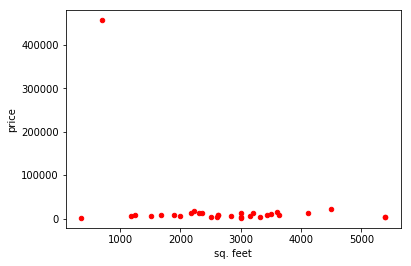

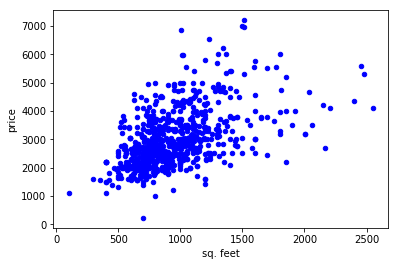

In [504]:
test[y==1].plot('sq. feet', 'price',kind='scatter',color='r')
test[y==0].plot('sq. feet', 'price',kind='scatter',color='b')

In [417]:
#complex p?

In [1060]:



#fix to 1 bedrooms and look at probability distribution in the two dimensions of square footage and price
sqfeetrange = np.arange(0,5000,100);
pricerange = np.arange(0,10000,100);
X, Y = np.meshgrid( sqfeetrange, pricerange);

Z = np.array([[p(np.array([1,x,y]),mu,Sig) for x in sqfeetrange] for y in pricerange])




from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter


fig = plt.figure()



ax = fig.gca(projection='3d')

ax.scatter([1000],[4000],p(np.array([1,1000,4000]),mu,Sig),color='k',marker = 'o')

surf = ax.plot_surface(X, Y, Z)#, cmap=cm.coolwarm)#,
                       #linewidth=0, antialiased=False)
ax.set_xlabel('sq. feet')
ax.set_ylabel('price')



IndexError: too many indices for array

In [449]:
np.sqrt(detSig)

0.26390435668938306

In [970]:
#average price per room for 1 br, 2br, 3br
#[np.mean(df.loc[df['bedrooms']==i]['price'])/i for i in range(1,6)]

In [971]:
#df.loc[df['price']>5000]

In [365]:
# old train and predict

#remove rows with missing data
# dfclean=df_no_duplicates.dropna()[:]

# dfclean['1000sqfeet']=dfclean['sq. feet']/1000  #normalize so all features are order 1 (no area is in 1000s of square feet)
# dfclean['pricek']=dfclean['price']/1000 #normalize so all features are order 1 (price is in thousands of dollars)

# #compute the mean
# mu = np.array(np.mean(dfclean)[['bedrooms','1000sqfeet','pricek']])
# xminusmu = np.array(dfclean[['bedrooms','1000sqfeet', 'pricek']]-mu)

# #compute covariance matrix
# m=xminusmu.shape[0]
# Sigi=0;
# for i in range(0,m):
#     Sigi=Sigi+np.outer(xminusmu[i], (xminusmu[i]).T)
# Sig=(1/m)*Sigi
# detSig = np.linalg.det(Sig)

# Siginv = np.linalg.inv(Sig)
# n=len(mu)
# def p(x):
#     #p takes x in [bedrooms, 1000s of square feet, 1000s of dollars]
#     exp=np.e**(-.5*np.dot(x-mu,np.dot(Siginv,x-mu)))
#     return(exp/( (2*np.pi)**(n/2)*(detSig**(1/2)) ))
    
# #set a 1-sigma cut-off?
# def predict(x):
#     #x = [bedrooms, square feet, price (in dollars)]
#     eps = p(mu-[Sig[0,0],(Sig[1,1]),Sig[2,2]  ]);
#     y = np.array([x[0], x[1]/1000, x[2]/1000])
#     if p(y)>=eps:  #p takes x in [bedrooms, 1000s of square feet, 1000s of dollars]
#         print(f"A {np.round(x[1])} sq. foot {int(x[0])}-bedroom home for ${np.round(x[2],2)} is not anomalous.")
#     else:
#         print(f"A {x[1]} sq. foot {x[0]}-bedroom home for ${x[2]} is anomalous.")    
    

Text(0.5,1,'Probability distribution for average bedrooms and area, as a functin of price')

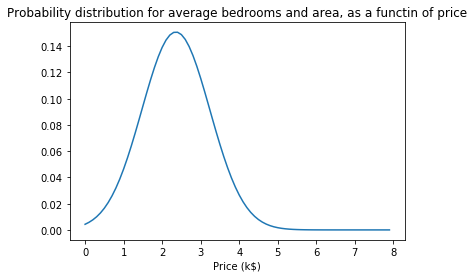

In [973]:
pricerange = np.arange(0,int(max(dfclean['pricek'])),.1);
xs = [[1,.8,price] for price in pricerange]
plt.plot([price for price in pricerange], [p(xs[i]) for i in range(0,len(xs))])
plt.xlabel('Price (k$)')
plt.title('Probability distribution for average bedrooms and area, as a functin of price')


In [974]:
x=np.zeros(3);
x[0]=1
x[1]=np.mean(dfclean.loc[dfclean['bedrooms']==x[0]]['1000sqfeet'])
x[2] = .5
x=np.array(x)
print(f"Check probability of feature vector {x}")
print(f"There's a {np.round(p(x)*100,2)}% chance that a {int(x[0])}-bedroom of average size \nwould cost ${x[2]*1000}. This is somewhat anomalous.")

Check probability of feature vector [1.         0.72616667 0.5       ]
There's a 2.19% chance that a 1-bedroom of average size 
would cost $500.0. This is somewhat anomalous.


In [975]:
predict(np.array([3,1000,3500]))

A 1000 sq. foot 3-bedroom home for $3500 is anomalous.


In [976]:
#now i need to get more data by scraping other pages,
# and properly split my data into training/testing (don't think i need CV for anything?)

In [548]:
re.compile('[a-z ]+').search(resultrow.find(class_="result-hood").text.strip()).group() for resultrow in resultrows


'lower pac hts'

In [546]:
lowerpachts=resultrows[3].find(class_="result-hood").text.strip()

re.compile('[a-z ]+').findall(lowerpachts)

['lower pac hts']

In [520]:
resultrows.find_all(class_="result-hood")

AttributeError: ResultSet object has no attribute 'find_all'. You're probably treating a list of items like a single item. Did you call find_all() when you meant to call find()?

# other cleaning considerations

In [239]:

#plenty list price zero. obviously this is false.
df[df['price']==0]

#extract the most expensive neighborhoods?

nhp=[];
for nh in hoods:
    nhp.append([nh, np.mean(df[df['neighborhood']==nh]['price'])])
    
    
pd.DataFrame(nhp,columns=['neighborhood','average price']).sort_values(by='average price',ascending=False)


,neighborhood,average price
8,clarendon heights -,25000.000000
130,"hillsborough, ca",16000.000000
111,kentfield / ross,10650.000000
109,laurel hts / presidio,9300.000000
65,soma,6190.000000
28,financial district,5903.461538
141,tiburon / belvedere,5901.666667
36,rincon hill,5790.000000
53,cole valley / ashbury hts,5373.750000
23,saratoga,5100.000000
